# Verification of SOL 106's Nonlinear Buckling Method

In this notebook we want to perform a verification study on SOL 106's nonlinear buckling method. This study is inspired by the verification of the nonlinear buckling method presented by [Lee & Herting (1985)](https://onlinelibrary.wiley.com/doi/pdf/10.1002/nme.1620211016). In their paper, the authors mentioned that the nonlinear buckling method should be applicable to linear problems because linear buckling is a special case of nonlinear buckling. For this reason they tested the nonlinear buckling method on Euler's column, analogously to what we did in our [first notebook](01_Buckling_Analysis_of_Euler_Column.ipynb).

Since in our [last notebook](05_Sensitivity_Study_of_SOL_106_Nonlinear_Analysis_Parameters.ipynb) we found out that the box beam appears to behave linearly up to the buckling load predicted by SOL 105, here we follow the same reasoning of Lee & Herting and we apply the nonlinear buckling method to verify whether we are able to reproduce the results of the linear analysis. We will also test the nonlinear buckling method beyond the buckling load predicted by SOL 105 to observe how the method behaves.

* [Problem definition](#problem)
* [Setup of the numerical model](#numerical-model)
* [Nonlinear buckling method verification](#verification)
* [Tangent stiffness matrix assessment](#tangent-stiffness-matrix)
* [Conclusions](#conclusions)

## Problem definition <a name="problem"></a>

***

We consider the same box beam model that we used in our [last notebook](05_Sensitivity_Study_of_SOL_106_Nonlinear_Analysis_Parameters.ipynb), that is to say with a rigid tip section and a concentrated load applied at the center of such section.

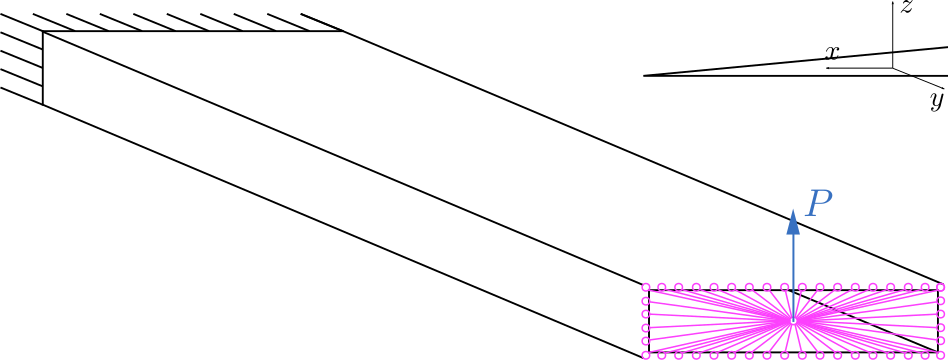

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '04_BoxBeamConcentratedLoad.svg'))

In [2]:
AR = 9.   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.1f} m\n- span: {b/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm')

Box beam dimensions:
- width: 1.0 m
- span: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


In [3]:
rho = 2780e-12 # density [ton/mm^3]
E = 73.1e3 # Young's modulus [MPa]
nu = 0.3 # Poisson's ratio

## Setup of the numerical model <a name="numerical-model"></a>

***

We discretize the geometry of our box beam into quadrilateral elements using the function `mesh_box` from the `box_beam_utils` module. For that we use a target shell element edge length of 86 mm, following the results of our previous [mesh convergence study](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb#mesh-convergence).

In [4]:
from resources import box_beam_utils

edge_length = 86  # [mm]
nodes_coordinates_array, nodes_connectivity_matrix = box_beam_utils.mesh_box(width=w, span=b, height=h, edge_length=edge_length)

Then we create a base bdf input using the function `create_base_bdf_input` and we print a summary of the bulk data cards that were defined in the input.

In [5]:
box_beam_bdf_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
print(box_beam_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 1760

bdf.elements: 0
  CQUAD4   : 1728

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Now we need to make the tip section of the box beam rigid and to apply a concentrated load as shown earlier. For this purpose we add a master node at the center of the tip section, add a RBE2 element to make the section rigid and add a FORCE card to define a force along the $z$-axis applied at the master node.

In [6]:
import numpy as np

# Add master node of tip section
master_node_id = np.size(nodes_coordinates_array, 0) + 1
box_beam_bdf_input.add_grid(master_node_id, [w/2, b, 0.])

# Add RBE2 element to make tip section rigid
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tip_nodes_ids = nodes_ids[nodes_coordinates_array[:,1]==b]
rbe2_eid = len(box_beam_bdf_input.elements) + 1
box_beam_bdf_input.add_rbe2(rbe2_eid, master_node_id, '123456', tip_nodes_ids)

# Add concentrated force
force_set_id = 11
concentrated_force_magnitude = 1.
concentrated_force_direction = [0., 0., 1.]
box_beam_bdf_input.add_force(sid=force_set_id, node=master_node_id, mag=concentrated_force_magnitude, xyz=concentrated_force_direction)

FORCE         11    1761              1.      0.      0.      1.

## Nonlinear buckling method verification <a name="verification"></a>

***

Given the linear behavior observed for our box beam in our previous notebook, with this analysis we want to verify whether we are able to obtain the same buckling load predicted by SOL 105 with SOL 106's nonlinear buckling method. We are going to test this hypothesis for different applied loads ranging from a fraction of the buckling load predicted by SOL 105 to twice its value, as we are also interested in checking the results of the nonlinear buckling method for applied loads larger than the linear prediction.

In order to execute this sweep, we define the function `run_nonlinear_buckling_method_sweep` in an analogous way as we did in our [fourth notebook](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb#disrtibuted-load-flexible-tip).

In [7]:
from resources import pynastran_utils
from pyNastran.op2.op2 import read_op2

# Function to set up the nonlinear analysis with the nonlinear buckling methods for increasing applied loads
def run_nonlinear_buckling_method_sweep(bdf_input, load_magnitudes, input_filename, run_flag=True):
    # Set up nonlinear analysis with arc-length method
    pynastran_utils.set_up_arc_length_method(bdf_object=bdf_input, ninc=100, max_iter=25, conv='PUV', eps_p=1e-3, eps_u=1e-3, max_bisect=10, minalr=.01, maxalr=1.1, desiter=5, maxinc=1000)
    # Define parameters for buckling analysis
    bdf_input.add_param('BUCKLE', [2])
    eigrl_sid = force_set_id+1
    bdf_input.add_eigrl(sid=eigrl_sid, v1=0., nd=1)  # calculate only the first positive eigenvalue
    bdf_input.case_control_deck.subcases[0].add_integer_type('METHOD', eigrl_sid)
    # Create the LOAD cards corresponding to the input load magnitudes and the associated subcases
    for i, scale_factor in enumerate(load_magnitudes):
        load_set_id = 21+i
        bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])
        pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=i+1, load_set_id=load_set_id)
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=input_filename, run_flag=run_flag)
    # Read op2 file
    op2_path = os.path.join(analysis_directory_path, input_filename + '.op2')
    op2 = read_op2(op2_filename=op2_path, load_geometry=True, debug=None)
    # Return op2 object
    return op2

Then we recall the buckling load predicted by SOL 105 and we define 11 load magnitudes equally spaced between 0 and twice the linear buckling load. We discard the load case with null magnitude and we keep the other 10 load cases.

In [8]:
linear_buckling_load = 1657   # [N]
applied_load_magnitudes = np.linspace(0, 2*linear_buckling_load, 11)[1:]
np.set_printoptions(precision=0, suppress=True)
print(f'Applied loads [N]: {applied_load_magnitudes}')

Applied loads [N]: [ 331.  663.  994. 1326. 1657. 1988. 2320. 2651. 2983. 3314.]


Let's define the analysis folder and run our first nonlinear buckling load sweep.

In [9]:
# Define name of analysis directory
analysis_directory_name = '06_Verification_of_SOL_106_Nonlinear_Buckling_Method'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)

# Run analysis
input_name = 'nonlinear_buckling_verification'
op2_output = run_nonlinear_buckling_method_sweep(box_beam_bdf_input.__deepcopy__({}), applied_load_magnitudes, input_name, run_flag=False)

Nastran job nonlinear_buckling_verification.bdf completed
Wall time: 102.0 s


Analogously to what we did in our fourth notebook, we define the function `plot_buckling_loads` to plot the buckling loads predicted by SOL 106 $P_\text{SOL 106}$ and the critical buckling factors $\alpha$ against the applied load $P$. Both loads are nondimensionalized with the buckling load predicted by SOL 105. Subsequently, we read the nonlinear buckling loads and the critical buckling factors from the f06 file using the function `read_nonlinear_buckling_load_from_f06` and we plot the results of our analysis.

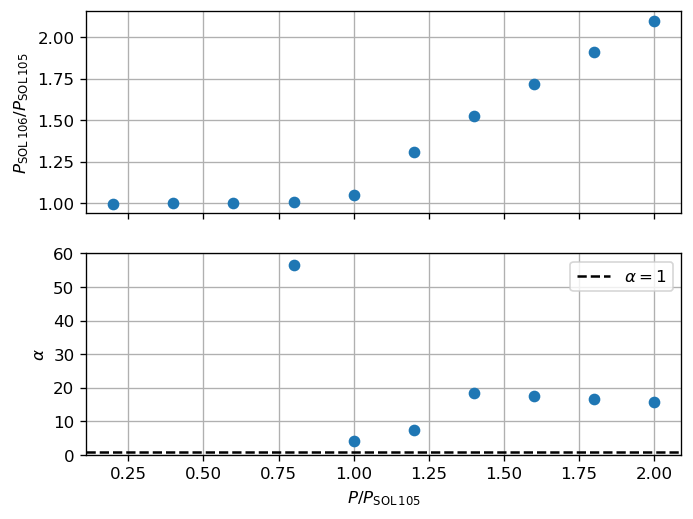

In [10]:
import matplotlib.pyplot as plt

# Function to plot SOL 106 buckling loads and critical buckling factors against applied loads
def plot_buckling_loads(applied_loads, sol_105_buckling_load, sol_106_buckling_loads, alphas):
    _, axs = plt.subplots(nrows=2, ncols=1, sharex='all')  # figure with 2 subplots
    axs[0].plot(applied_loads/sol_105_buckling_load, sol_106_buckling_loads/sol_105_buckling_load, 'o')  # buckling loads vs applied loads
    axs[1].plot(applied_loads/sol_105_buckling_load, alphas, 'o')  # critical buckling factors vs applied loads
    axs[1].axhline(y=1, color='k', ls='--', label='$\\alpha=1$')  # alpha=1 reference line
    # Set plot appearance
    axs[0].set_ylabel('$P_\mathrm{SOL\/106}/P_\mathrm{SOL\/105}$')
    axs[0].grid(visible=True)
    axs[1].set_ylabel('$\\alpha$')
    axs[1].grid(visible=True)
    axs[1].legend()
    axs[1].set_xlabel('$P/P_\mathrm{SOL\/105}$')
    axs[1].set_ylim([0, 60])
    plt.show()

# Set default dpi of figures
plt.rcParams['figure.dpi'] = 120

# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_name + '.f06'), op2_object=op2_output)

# Plot results
plot_buckling_loads(applied_load_magnitudes, linear_buckling_load, nonlinear_buckling_loads, critical_buckling_factors)

The results show that the nonlinear buckling method predicts the same buckling load of SOL 105 for $P/P_\text{SOL 105}<1$, confirming that in the linear regime the nonlinear buckling method is able to predict the same buckling load of SOL 105. For $P/P_\text{SOL 105}\geq1$ the nonlinear buckling method predicts a larger buckling load than SOL 105 and we observe a nearly linear relation between applied load and nonlinear buckling load. In our [previous notebook](05_Sensitivity_Study_of_SOL_106_Nonlinear_Analysis_Parameters.ipynb#sensitivity), we observed that the deformed shape of the box beam for $P/P_\text{SOL 105}=1$ features a buckled-like state of the top skin, suggesting that some nonlinearities may come into play, hence the different buckling load predicted by SOL 106. However, it is not clear why the nonlinear buckling method predicts a larger buckling load than SOL 105 and the reason of the seemingly linear behavior between applied load and nonlinear buckling load.

As far as the critical buckling factor $\alpha$ is concerned, we always observe a value well above 1. However, we note that we need to be interested in a small value of $\alpha$ only if we want to accurately pinpoint the value of the critical buckling load in the presence of nonlinear effects. In fact, we must remember that SOL 106's nonlinear buckling method is based on the linearization of the variation of the tangent stiffness matrix between the last two converged solutions of each subcase. As a consequence, the large values of $\alpha$ for $P/P_\text{SOL 105}<1$ should not be a surprise, as we are linearizing the variation of the tangent stiffness matrix relatively far from the buckling load predicted by SOL 105. Despite the large values of $\alpha$, the predicted nonlinear buckling load makes sense, because in the linear regime of the structural behavior the nonlinear buckling method is supposed to predict the same (or very similar) critical bucklig load of the linear analysis. On the other hand, it is unclear why $\alpha$ is always positive and larger than 1 in the seemingly nonlinear regime of the structural behavior, that is to say for $P/P_\text{SOL 105}\geq1$, as this seems to suggest that the buckling load keeps being pushed up as the applied load increases.

Let's plot the equilibrium diagram of the structure in terms of applied load vs tip displacement. We read the load and displacement history from the `OP2` object using the function `read_load_displacement_history_from_op2`, collect together the applied loads and the tip displacements along the $z$-axis of all subcases and make the plot.

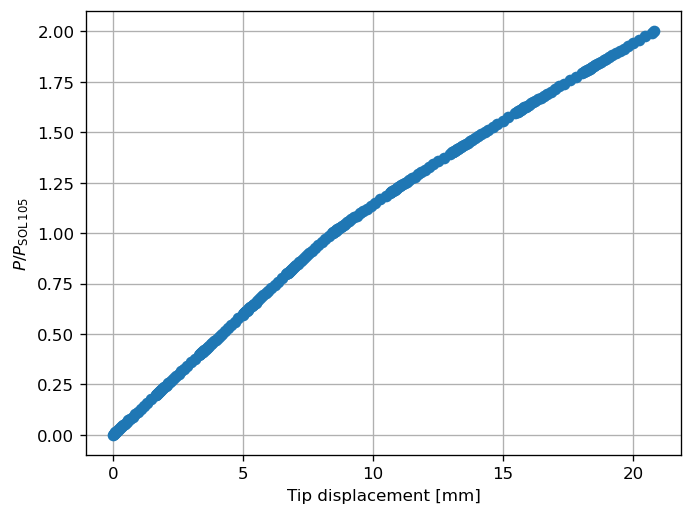

In [11]:
# Find load and displacement history
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)

# Collect load and displacement history
load_component_index = 2  # select z-axis component of the load
displacement_component_index = 2  # select z-axis component of the displacement
load_history = np.concatenate([loads[subcase_id][:, load_component_index] for subcase_id in displacements])  # concatenate applied load arrays of all subcases
displacement_history = np.concatenate([displacements[subcase_id][:,displacement_component_index] for subcase_id in displacements])  # concatenate displacement arrays of all subcases

# Plot load-displacement diagram
_, ax = plt.subplots()
ax.plot(displacement_history, load_history/linear_buckling_load, 'o')
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.grid()
plt.show()

We observe a change in the slope of the load-displacement diagram approximately for $P/P_\text{SOL 105}=1$. This can be most probably ascribed to the buckled-like deformation of the top skin that we observed in our [previous notebook](05_Sensitivity_Study_of_SOL_106_Nonlinear_Analysis_Parameters.ipynb#sensitivity).

Let's plot the deformation of the box beam at the end of the analysis ($P/P_\text{SOL 105}=2$) to verify the state of the top skin.

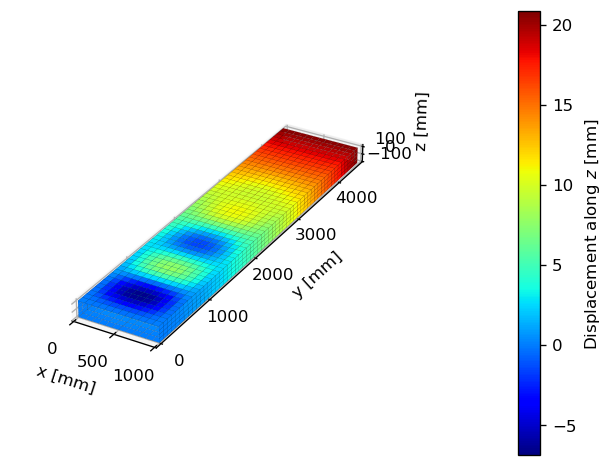

In [12]:
valid_subcase_ids = [subcase_id for subcase_id in op2_output.load_vectors if hasattr(op2_output.load_vectors[subcase_id], 'lftsfqs')]  # find ids of the subcases associated with static nonlinear analysis
_, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output, subcase_id=valid_subcase_ids[-1], displacement_component='tz')  # plot static deformation at the end of the last subcase
ax.locator_params(axis='x', nbins=3)  # set number of x-axis ticks
ax.locator_params(axis='z', nbins=2)  # set number of z-axis ticks
ax.tick_params(axis='y', which='major', pad=20)  # set distance of y-axis tick labels
ax.tick_params(axis='z', which='major', pad=6)  # set distance of z-axis tick labels
ax.yaxis.labelpad = 60  # set distance of y-axis label
ax.zaxis.labelpad = 10  # set distance of z-axis label
plt.show()  # show plot

We can see that the top skin develops a clear buckled-like shape for $P/P_\text{SOL 105}=2$. As a consequence we can conclude that the nonlinearity observed in the load-displacement diagram must be caused by the deformation state of the top skin for $P/P_\text{SOL 105}\geq1$, which affects the global stiffness of the box beam.

Given the obscurity of the nonlinear buckling method results for $P/P_\text{SOL 105}\geq1$ let's repeat our analysis for a set of applied loads more zoomed around $P/P_\text{SOL 105}=1$. We define 10 applied loads ranging from $P/P_\text{SOL 105}=0.75$ to $P/P_\text{SOL 105}=1.25$, run the analysis and plot nonlinear buckling loads and critical bukling factors versus the applied loads.

Applied loads [N]: [1243. 1335. 1427. 1519. 1611. 1703. 1795. 1887. 1979. 2071.]
Nastran job nonlinear_buckling_verification_zoomed.bdf completed
Wall time: 77.0 s


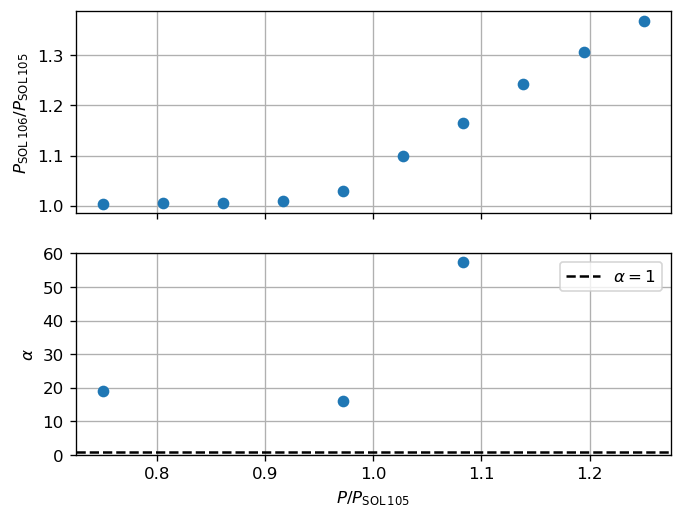

In [13]:
# Define applied loads
applied_load_magnitudes = np.linspace(.75*linear_buckling_load, 1.25*linear_buckling_load, 10)
print(f'Applied loads [N]: {applied_load_magnitudes}')

# Run analysis
input_name = 'nonlinear_buckling_verification_zoomed'
op2_output = run_nonlinear_buckling_method_sweep(box_beam_bdf_input.__deepcopy__({}), applied_load_magnitudes, input_name, run_flag=False)

# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_name + '.f06'), op2_object=op2_output)

# Plot SOL 106 buckling loads and critical buckling factors
plot_buckling_loads(applied_load_magnitudes, linear_buckling_load, nonlinear_buckling_loads, critical_buckling_factors)

These results suggest a slightly more gradual change of the nonlinear buckling load than what we observed earlier, where initially SOL 106 predicts a buckling load similar to SOL 105 and then it transitions to a linear relation between applied load and buckling load. The critical buckling factor $\alpha$ seems to have a more erratic behavior with respect to what we observed earlier. However, it still suggests that the two last converged solutions of each subcase are always relatively far from the predicted critical buckling load.

What does this mean? A possible explanation can be considered taking inspiration from the Euler's column. In our [second notebook](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb) we observed the "break" of the supercritical pitchfork bifurcation when we applied an eccentric load. In an analogous way, it is possible that under a bending load the bifurcation potentially corresponding to the critical buckling load of the box beam breaks down and we are left with a broken bifurcation path. In order to verify this, we need to repeat our nonlinear analysis monitoring the lowest eigenvalue of the tangent stiffness matrix for each converged iteration.

## Tangent stiffness matrix assessment <a name="tangent-stiffness-matrix"></a>

***

Let's create a copy of the original base bdf input, set up the nonlinear analysis with the arc-length method, define the parameters for the calculation of the lowest eigenvalue of the tangent stiffness matrix $\mathbf{K_T}$, set the applied load magnitude to twice the buckling load predicted by SOL 105 and run the analysis.

In [14]:
# Create deep copy of bdf object and set up nonlinear analysis with the arc-length method
box_beam_tangent_stiffness_matrix_input = box_beam_bdf_input.__deepcopy__({})
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_tangent_stiffness_matrix_input, ninc=200, max_iter=25, conv='PUV', eps_p=1e-3, eps_u=1e-3, max_bisect=10, minalr=.01, maxalr=2., desiter=2, maxinc=1000)

# Define parameters for the calculation of the lowest eigenvalue of the tangent stiffness matrix
box_beam_tangent_stiffness_matrix_input.add_param('BUCKLE', [2])  # request nonlinear buckling method
eigrl_set_id = force_set_id+1  # set identification number of EIGRL card
box_beam_tangent_stiffness_matrix_input.add_eigrl(sid=eigrl_set_id, v1=0., nd=1)  # calculate only the first positive eigenvalue
box_beam_tangent_stiffness_matrix_input.case_control_deck.subcases[0].add_integer_type('METHOD', eigrl_set_id)  # add EIGRL card id to case control deck
box_beam_tangent_stiffness_matrix_input.executive_control_lines[1:1] = ['include \'' + os.path.join(os.pardir, os.pardir, 'resources', 'kllrh_lowest_eigenvalues_nobuckle.dmap') + '\'']  # include DMAP sequence

# Define force magnitude and create subcase
box_beam_tangent_stiffness_matrix_input.loads[force_set_id][0].mag = linear_buckling_load*2
first_subcase_id = 1
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_tangent_stiffness_matrix_input, subcase_id=first_subcase_id, load_set_id=force_set_id)

# Run analysis
input_name = 'tangent_stiffness_matrix'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_tangent_stiffness_matrix_input, filename=input_name, run_flag=False)

Nastran job tangent_stiffness_matrix.bdf completed
Wall time: 173.0 s


Now we can read the load history from the op2 file, the lowest eigenvalues from the f06 file and plot how the latter versus the former.

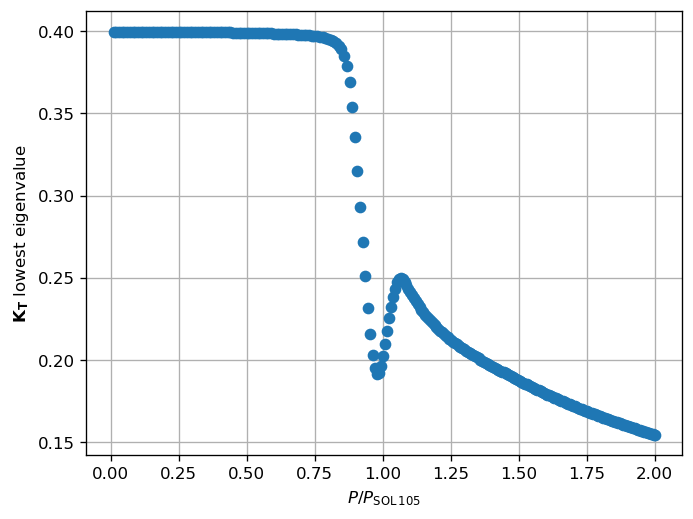

In [15]:
# Read load history from op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=None, load_geometry=True)
_, loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
load_history = np.concatenate([loads[subcase_id][:, load_component_index] for subcase_id in loads])

# Read the lowest eigenvalue of KLLRH matrices from f06 file
f06_filepath = os.path.join(analysis_directory_path, input_name + '.f06')  # path to .f06 file
lowest_eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)

# Create new figure and plot load history vs lowest eigenvalues
_, ax = plt.subplots()
ax.plot(load_history/linear_buckling_load, lowest_eigenvalues[0, :], 'o')
plt.xlabel('$P/P_\\mathrm{SOL\/105}$')
plt.ylabel('$\mathbf{K_T}$ lowest eigenvalue')
plt.grid()
plt.show()

We observe that the lowest eigenvalue of the tangent stiffness matrix is initially nearly constant, hence the linear regime, it drops after $P/P_\text{SOL 105}=0.75$, reaches a minimum just before $P/P_\text{SOL 105}=1$ and then it increases before decreasing again. We note that the lowest eigenvalue is always positive for the investigated load range and, as a consequence, the tangent stiffness matrix is always positive definite. This means that our box beam does not encounter any critical point, where the lowest eigenvalue should become null, and it is always in a stable equilibrium. As a consequence, this last result seems to confirm the idea that the bifurcation of the box beam under a bending load is actually broken.

## Conclusions

***

In this notebook we have verified that SOL 106's nonlinear buckling method predicts a similar critical buckling load to SOL 105 for an applied load in the linear regime of the box beam. We also noted that the buckling load trend predicted by SOL 106 transitions to a linear relation with the applied load as the applied load increases above the buckling load predicted by SOL 105. In analogy with the behavior of the Euler's column, we have supposed that this may be caused by the break of the bifurcation corresponding to the critical buckling load. Investigating the change of the lowest eigenvalue of the tangent stiffness matrix with the applied load, we have verified that the structure is always stable and does not encounter any critical point, which seems to confirm our hypothesis.

In our [next notebook](07_Verification_of_SOL_106_Nonlinear_Buckling_Method_for_the_Imperfect_Euler_Column.ipynb) we are going to repeat the verification of SOL 106's nonlinear buckling method and of the positive definiteness of the tangent stiffness matrix for the imperfect Euler's column, that is to say an Euler's column with a slight eccentricity in the applied compression load.